In [244]:
import pandas as pd
from odf.opendocument import load
from odf.table import Table, TableRow, TableCell
from odf.text import P

# 2016 Data

Preliminary finding: Kostenstellen sind teilweise nicht vorhanden (bspw. gemäss Kostenstellen Übersicht ist Kultur = 291 nach HRM1 und 2300 nach HRM2). Im File ist die Kultur-Kostenstelle 201.

### Load .ods file and format as df

In [245]:
def read_ods(filename, sheet_no=0):
    """
    Read a sheet from an ODS file and return a Pandas DataFrame with headers.

    :param filename: Path to the ODS file.
    :param sheet_no: Sheet number to read (starting from 0).
    :return: Pandas DataFrame containing the data from the sheet.
    """
    doc = load(filename)
    sheet = doc.spreadsheet.getElementsByType(Table)[sheet_no]
    data = []
    for row in sheet.getElementsByType(TableRow):
        row_data = []
        for cell in row.getElementsByType(TableCell):
            cell_content = ''
            for p in cell.getElementsByType(P):
                if p.firstChild:
                    cell_content += p.firstChild.data
            row_data.append(cell_content)
        data.append(row_data)

    # Convert to DataFrame, assuming first row is the header
    df = pd.DataFrame(data)
    header = df.iloc[0]
    df = df[1:]
    df.columns = header
    return df

# Replace 'your_file.ods' with the path to your ODS file
ods_file = '2016_Laufende Rechnung 3-stellig.ods'

# Read the first sheet from the ODS file
df_2016 = read_ods(ods_file)

# Print the head of the DataFrame
df_2016.head()


,Typ,Rechnung 2015,Voranschlag 2016,Voranschlag,Konto,,Rechnung 2016 Aufwand,Rechnung 2016 Ertrag,Abweichung von Budget u. Nachtr.,
1,F,,,,T,Laufende Rechnung Stadt St. Gallen,,,,None
2,F,660’847’764.66,657’169’675,,Aufwand,662’011’534.12,,-12’139’841,,None
3,F,,3’419’500,S,,,,,None,None
4,F,,13’562’200,P,,,,,None,None
5,F,666’354’012.13,650’851’525,,Ertrag,,667’790’892.41,16’939’367,,None


In [246]:
# #Checking dtype of column 'Konto'
# numeric_column_type = df_2016['Konto'].dtype
# print(f"Data type of 'Konto': {numeric_column_type}")


Convert dtype from "object" to "float64"

In [247]:
# Convert 'Konto' column to float64
df_2016['Konto'] = pd.to_numeric(df_2016['Konto'], errors='coerce')
numeric_column_type = df_2016['Konto'].dtype
print(f"Data type of 'Konto': {numeric_column_type}")

Data type of 'Konto': float64


### In the following section, I aggregate entries by kst

In [248]:
# Fill empty cells in 'Konto' with the value from the previous row
df_2016['Konto'] = df_2016['Konto'].ffill()

# Display the updated DataFrame
df_2016

,Typ,Rechnung 2015,Voranschlag 2016,Voranschlag,Konto,,Rechnung 2016 Aufwand,Rechnung 2016 Ertrag,Abweichung von Budget u. Nachtr.,
1,F,,,,NaN,Laufende Rechnung Stadt St. Gallen,,,,None
2,F,660’847’764.66,657’169’675,,NaN,662’011’534.12,,-12’139’841,,None
3,F,,3’419’500,S,NaN,,,,None,None
4,F,,13’562’200,P,NaN,,,,None,None
5,F,666’354’012.13,650’851’525,,NaN,,667’790’892.41,16’939’367,,None
...,...,...,...,...,...,...,...,...,...,...
2607,N,422’026.55,,,480.00,Entnahmen aus Spezialfinanzierungen und Stiftu...,,,,None
2608,N,825’379.25,1’555’200,,490.00,Intern verrechneter Ertrag,,1’598’857.80,43’658,
2609,N,18’399.90,10’800,,496.00,Intern verrechnete Zinsen,,16’350.90,5’551,
2610,,,,,496.00,,,None,None,None


In [249]:
# Initialize 'kst' column
df_2016['kst'] = None

# Track the last 'F' value in 'Konto'
last_f_value = None

# Iterate through DataFrame rows
for index, row in df_2016.iterrows():
    if row['Typ'] == 'F':
        last_f_value = row['Konto']
    df_2016.at[index, 'kst'] = last_f_value

# Print the updated DataFrame
df_2016

,Typ,Rechnung 2015,Voranschlag 2016,Voranschlag,Konto,,Rechnung 2016 Aufwand,Rechnung 2016 Ertrag,Abweichung von Budget u. Nachtr.,,kst
1,F,,,,NaN,Laufende Rechnung Stadt St. Gallen,,,,None,NaN
2,F,660’847’764.66,657’169’675,,NaN,662’011’534.12,,-12’139’841,,None,NaN
3,F,,3’419’500,S,NaN,,,,None,None,NaN
4,F,,13’562’200,P,NaN,,,,None,None,NaN
5,F,666’354’012.13,650’851’525,,NaN,,667’790’892.41,16’939’367,,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2607,N,422’026.55,,,480.00,Entnahmen aus Spezialfinanzierungen und Stiftu...,,,,None,681.00
2608,N,825’379.25,1’555’200,,490.00,Intern verrechneter Ertrag,,1’598’857.80,43’658,,681.00
2609,N,18’399.90,10’800,,496.00,Intern verrechnete Zinsen,,16’350.90,5’551,,681.00
2610,,,,,496.00,,,None,None,None,681.00


Quality Check: Count 145 unique values of Typ "F"

In [250]:
# # Count unique values in 'kst' column
# unique_count = df_2016['kst'].nunique()

# # Print the count
# print(f"Number of unique values in 'kst': {unique_count}")

In [251]:
# Function to convert formatted string to float
def convert_to_float(s):
    if isinstance(s, str):
        return pd.to_numeric(s.replace("'", '').replace("’", ''), errors='coerce')
    return s

# Columns to convert
columns_to_convert = [
    'Rechnung 2015',
    'Voranschlag 2016',
    'Rechnung 2016 Aufwand',
    'Rechnung 2016 Ertrag',
    'Abweichung von Budget u. Nachtr.'
]

# Apply the function to the specified columns
for column in columns_to_convert:
    df_2016[column] = df_2016[column].apply(convert_to_float)

# Display the updated DataFrame
df_2016

,Typ,Rechnung 2015,Voranschlag 2016,Voranschlag,Konto,,Rechnung 2016 Aufwand,Rechnung 2016 Ertrag,Abweichung von Budget u. Nachtr.,,kst
1,F,NaN,NaN,,NaN,Laufende Rechnung Stadt St. Gallen,NaN,NaN,NaN,None,NaN
2,F,660'847'764.66,657'169'675.00,,NaN,662’011’534.12,NaN,-12'139'841.00,NaN,None,NaN
3,F,NaN,3'419'500.00,S,NaN,,NaN,NaN,NaN,None,NaN
4,F,NaN,13'562'200.00,P,NaN,,NaN,NaN,NaN,None,NaN
5,F,666'354'012.13,650'851'525.00,,NaN,,667'790'892.41,16'939'367.00,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2607,N,422'026.55,NaN,,480.00,Entnahmen aus Spezialfinanzierungen und Stiftu...,NaN,NaN,NaN,None,681.00
2608,N,825'379.25,1'555'200.00,,490.00,Intern verrechneter Ertrag,NaN,1'598'857.80,43'658.00,,681.00
2609,N,18'399.90,10'800.00,,496.00,Intern verrechnete Zinsen,NaN,16'350.90,5'551.00,,681.00
2610,,NaN,NaN,,496.00,,NaN,NaN,NaN,None,681.00


To test, whether all rows now have the additional column, run the following

In [252]:
# # Number to check
# number_to_check = 10  # Replace with the number you're looking for

# # Check if the number is present in either 'kst_bisher' or 'kst_neu'
# result_df = df_2016[(df_2016['kst'] == number_to_check)]

# if not result_df.empty:
#     # If the number is found, display the rows
#     print(result_df)
# else:
#     # If the number is not found, print a message
#     print("this kst does not exist")

The following shows the current formatting problem: in row "25", the .ods file is not correctly formatted and the columns shift one to the left :()

In [253]:
# result_df

In [254]:
# Create a new column 'IsNumeric' to categorize rows
df_2016['IsNumeric'] = df_2016['Konto'].apply(is_numeric)


In [255]:
# # Function to convert formatted string to float
# def convert_to_float(s):
#     if isinstance(s, str):
#         return pd.to_numeric(s.replace("'", '').replace("’", ''), errors='coerce')
#     return s

# # Columns to convert
# columns_to_convert = [
#     'Rechnung 2015',
#     'Voranschlag 2016',
#     'Rechnung 2016 Aufwand',
#     'Rechnung 2016 Ertrag',
#     'Abweichung von Budget u. Nachtr.'
# ]

# # Apply the function to the specified columns
# for column in columns_to_convert:
#     df_2016[column] = df_2016[column].apply(convert_to_float)

# # Display the updated DataFrame
# df_2016

Check results of a specific kst

In [256]:
# # Number to check
# number_to_check = 10  # Replace with the number you're looking for

# # Check if the number is present in either 'kst_bisher' or 'kst_neu'
# result_df = df_2016[(df_2016['kst'] == number_to_check)]

# if not result_df.empty:
#     # If the number is found, display the rows
#     print(result_df)
# else:
#     # If the number is not found, print a message
#     print("this kst does not exist")

In [257]:
# result_df['Abweichung von Budget u. Nachtr.'].sum()

In [258]:
# Drop rows where 'Abweichung von Budget u. Nachtr.' is NaN
df_2016_cleaned = df_2016.dropna(subset=['Abweichung von Budget u. Nachtr.'])

# Display the cleaned DataFrame
df_2016_cleaned

,Typ,Rechnung 2015,Voranschlag 2016,Voranschlag,Konto,,Rechnung 2016 Aufwand,Rechnung 2016 Ertrag,Abweichung von Budget u. Nachtr.,,kst,IsNumeric
20,N,84'810.00,96'400.00,,300.00,Behörden und Kommissionen,107'689.95,NaN,-410.00,,10.00,True
22,N,163.25,NaN,,303.00,Sozialversicherungsbeiträge,810.85,NaN,811.00,,10.00,True
23,N,9.30,NaN,,305.00,Unfallversicherungs-/Krankentaggeldbeiträge,89.30,NaN,89.00,,10.00,True
24,N,89'637.95,164'000.00,,310.00,Büromaterial und Drucksachen,131'682.50,NaN,-32'318.00,,10.00,True
26,N,7'229.75,26'000.00,,317.00,Spesenentschädigungen,20'878.90,NaN,-5'121.00,,10.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2603,N,NaN,185'200.00,,380.00,Einlagen in Spezialfinanzierungen und Stiftungen,414'376.35,NaN,229'176.00,,681.00,True
2605,N,137'983.30,130'800.00,,396.00,Intern verrechnete Zinsen,131'962.60,NaN,1'163.00,,681.00,True
2606,N,692'545.75,785'000.00,,398.00,Intern verrechnete Abschreibungen,739'264.15,NaN,-45'736.00,,681.00,True
2608,N,825'379.25,1'555'200.00,,490.00,Intern verrechneter Ertrag,NaN,1'598'857.80,43'658.00,,681.00,True


The following displays that there are various rows per KST

In [259]:
# Convert 'Konto' column to float64
df_2016_cleaned['kst'] = pd.to_numeric(df_2016_cleaned['kst'], errors='coerce')
numeric_column_type = df_2016_cleaned['kst'].dtype
print(f"Data type of 'kst': {numeric_column_type}")

Data type of 'kst': float64


C:\Users\domin\AppData\Local\Temp\ipykernel_11776\1022697978.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2016_cleaned['kst'] = pd.to_numeric(df_2016_cleaned['kst'], errors='coerce')


In [260]:
df_2016_cleaned

,Typ,Rechnung 2015,Voranschlag 2016,Voranschlag,Konto,,Rechnung 2016 Aufwand,Rechnung 2016 Ertrag,Abweichung von Budget u. Nachtr.,,kst,IsNumeric
20,N,84'810.00,96'400.00,,300.00,Behörden und Kommissionen,107'689.95,NaN,-410.00,,10.00,True
22,N,163.25,NaN,,303.00,Sozialversicherungsbeiträge,810.85,NaN,811.00,,10.00,True
23,N,9.30,NaN,,305.00,Unfallversicherungs-/Krankentaggeldbeiträge,89.30,NaN,89.00,,10.00,True
24,N,89'637.95,164'000.00,,310.00,Büromaterial und Drucksachen,131'682.50,NaN,-32'318.00,,10.00,True
26,N,7'229.75,26'000.00,,317.00,Spesenentschädigungen,20'878.90,NaN,-5'121.00,,10.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2603,N,NaN,185'200.00,,380.00,Einlagen in Spezialfinanzierungen und Stiftungen,414'376.35,NaN,229'176.00,,681.00,True
2605,N,137'983.30,130'800.00,,396.00,Intern verrechnete Zinsen,131'962.60,NaN,1'163.00,,681.00,True
2606,N,692'545.75,785'000.00,,398.00,Intern verrechnete Abschreibungen,739'264.15,NaN,-45'736.00,,681.00,True
2608,N,825'379.25,1'555'200.00,,490.00,Intern verrechneter Ertrag,NaN,1'598'857.80,43'658.00,,681.00,True


The following is a pure quality check

In [261]:
# # Filter and display rows where 'kst' is 10.0
# filtered_df = df_2016_cleaned[df_2016_cleaned['kst'] == 10.0]
# filtered_df

In [262]:
# filtered_df['Abweichung von Budget u. Nachtr.'].sum()

Group by kst

In [263]:
# Drop specified columns
columns_to_drop = ['Typ', 'Voranschlag', 'Konto','', 'IsNumeric']
df_2016_cleaned = df_2016_cleaned.drop(columns=columns_to_drop, errors='ignore')

# Group by 'Konto' and calculate the sum
grouped_df = df_2016_cleaned.groupby('kst').sum()

# Reset the index to default integer index
final_df_2016_reset = grouped_df.reset_index()

# Rename the column
final_df_2016_reset = final_df_2016_reset.rename(columns={'Abweichung von Budget u. Nachtr.': 'Abweichung 2016'})

# Display the grouped DataFrame with sums
final_df_2016_reset


,kst,Rechnung 2015,Voranschlag 2016,Rechnung 2016 Aufwand,Rechnung 2016 Ertrag,Abweichung 2016
0,10.00,404'785.85,668'700.00,644'166.85,1'500.00,-34'733.00
1,11.00,309'751.55,282'600.00,306'895.60,0.00,-27'804.00
2,12.00,2'406'996.10,2'458'000.00,2'312'523.55,107'521.60,-65'354.00
3,15.00,119'728.12,121'250.00,120'067.47,0.00,-3'382.00
4,17.00,297'379.74,355'600.00,377'206.99,5'409.60,-13'884.00
...,...,...,...,...,...,...
109,645.00,205'221.25,239'400.00,76'341.60,627'676.30,464'617.00
110,660.00,2'130'870.02,2'175'500.00,1'155'523.55,1'027'920.00,7'942.00
111,661.00,1'409'021.90,1'418'800.00,1'093'607.80,382'270.80,57'079.00
112,680.00,2'234'849.04,2'129'300.00,2'093'591.80,151'224.15,39'516.00


# 2017 Data

In [264]:
def read_ods(filename, sheet_no=0):
    """
    Read a sheet from an ODS file and return a Pandas DataFrame with headers.

    :param filename: Path to the ODS file.
    :param sheet_no: Sheet number to read (starting from 0).
    :return: Pandas DataFrame containing the data from the sheet.
    """
    doc = load(filename)
    sheet = doc.spreadsheet.getElementsByType(Table)[sheet_no]
    data = []
    for row in sheet.getElementsByType(TableRow):
        row_data = []
        for cell in row.getElementsByType(TableCell):
            cell_content = ''
            for p in cell.getElementsByType(P):
                if p.firstChild:
                    cell_content += p.firstChild.data
            row_data.append(cell_content)
        data.append(row_data)

    # Convert to DataFrame, assuming first row is the header
    df = pd.DataFrame(data)
    header = df.iloc[0]
    df = df[1:]
    df.columns = header
    return df

# Replace 'your_file.ods' with the path to your ODS file
ods_file = '2017_Laufende Rechnung 3-stellig.ods'

# Read the first sheet from the ODS file
df_2017 = read_ods(ods_file)

# Print the head of the DataFrame
df_2017.head()


,Typ,Rechnung 2016,Voranschlag 2017,Voranschlag,Konto,,Rechnung 2017 Aufwand,Rechnung 2017 Ertrag,Abweichung von Budget u. Nachtr.,
1,F,,,,T,Laufende Rechnung Stadt St. Gallen,,,,None
2,F,662’011’534.12,666’858’010,,Aufwand,671’297’401.71,,-4’887’508,,None
3,F,,2’661’500,S,,,,,None,None
4,F,,6’665’400,P,,,,,None,None
5,F,667’790’892.41,662’887’670,,Ertrag,,683’393’698.75,20’506’029,,None


In [265]:
# Convert 'Konto' column to float64
df_2017['Konto'] = pd.to_numeric(df_2017['Konto'], errors='coerce')
numeric_column_type = df_2017['Konto'].dtype
print(f"Data type of 'Konto': {numeric_column_type}")

Data type of 'Konto': float64


In [266]:
# Fill empty cells in 'Konto' with the value from the previous row
df_2017['Konto'] = df_2017['Konto'].ffill()

# Display the updated DataFrame
df_2017

,Typ,Rechnung 2016,Voranschlag 2017,Voranschlag,Konto,,Rechnung 2017 Aufwand,Rechnung 2017 Ertrag,Abweichung von Budget u. Nachtr.,
1,F,,,,NaN,Laufende Rechnung Stadt St. Gallen,,,,None
2,F,662’011’534.12,666’858’010,,NaN,671’297’401.71,,-4’887’508,,None
3,F,,2’661’500,S,NaN,,,,None,None
4,F,,6’665’400,P,NaN,,,,None,None
5,F,667’790’892.41,662’887’670,,NaN,,683’393’698.75,20’506’029,,None
...,...,...,...,...,...,...,...,...,...,...
2814,N,1’598’857.80,1’581’100,,490.00,Intern verrechneter Ertrag,,1’666’961.55,85’862,
2815,N,16’350.90,17’300,,496.00,Intern verrechnete Zinsen,,25’754.00,8’454,
2816,,,,,496.00,,,None,None,None
2817,,,,,496.00,,,None,None,None


In [267]:
# Initialize 'kst' column
df_2017['kst'] = None

# Track the last 'F' value in 'Konto'
last_f_value = None

# Iterate through DataFrame rows
for index, row in df_2017.iterrows():
    if row['Typ'] == 'F':
        last_f_value = row['Konto']
    df_2017.at[index, 'kst'] = last_f_value

# Print the updated DataFrame
df_2017

,Typ,Rechnung 2016,Voranschlag 2017,Voranschlag,Konto,,Rechnung 2017 Aufwand,Rechnung 2017 Ertrag,Abweichung von Budget u. Nachtr.,,kst
1,F,,,,NaN,Laufende Rechnung Stadt St. Gallen,,,,None,NaN
2,F,662’011’534.12,666’858’010,,NaN,671’297’401.71,,-4’887’508,,None,NaN
3,F,,2’661’500,S,NaN,,,,None,None,NaN
4,F,,6’665’400,P,NaN,,,,None,None,NaN
5,F,667’790’892.41,662’887’670,,NaN,,683’393’698.75,20’506’029,,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2814,N,1’598’857.80,1’581’100,,490.00,Intern verrechneter Ertrag,,1’666’961.55,85’862,,681.00
2815,N,16’350.90,17’300,,496.00,Intern verrechnete Zinsen,,25’754.00,8’454,,681.00
2816,,,,,496.00,,,None,None,None,681.00
2817,,,,,496.00,,,None,None,None,681.00


In [268]:
# Function to convert formatted string to float
def convert_to_float(s):
    if isinstance(s, str):
        return pd.to_numeric(s.replace("'", '').replace("’", ''), errors='coerce')
    return s

# Columns to convert
columns_to_convert = [
    'Rechnung 2016',
    'Voranschlag 2017',
    'Rechnung 2017 Aufwand',
    'Rechnung 2017 Ertrag',
    'Abweichung von Budget u. Nachtr.'
]

# Apply the function to the specified columns
for column in columns_to_convert:
    df_2017[column] = df_2017[column].apply(convert_to_float)

# Display the updated DataFrame
df_2017

,Typ,Rechnung 2016,Voranschlag 2017,Voranschlag,Konto,,Rechnung 2017 Aufwand,Rechnung 2017 Ertrag,Abweichung von Budget u. Nachtr.,,kst
1,F,NaN,NaN,,NaN,Laufende Rechnung Stadt St. Gallen,NaN,NaN,NaN,None,NaN
2,F,662'011'534.12,666'858'010.00,,NaN,671’297’401.71,NaN,-4'887'508.00,NaN,None,NaN
3,F,NaN,2'661'500.00,S,NaN,,NaN,NaN,NaN,None,NaN
4,F,NaN,6'665'400.00,P,NaN,,NaN,NaN,NaN,None,NaN
5,F,667'790'892.41,662'887'670.00,,NaN,,683'393'698.75,20'506'029.00,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2814,N,1'598'857.80,1'581'100.00,,490.00,Intern verrechneter Ertrag,NaN,1'666'961.55,85'862.00,,681.00
2815,N,16'350.90,17'300.00,,496.00,Intern verrechnete Zinsen,NaN,25'754.00,8'454.00,,681.00
2816,,NaN,NaN,,496.00,,NaN,NaN,NaN,None,681.00
2817,,NaN,NaN,,496.00,,NaN,NaN,NaN,None,681.00


In [269]:
# Create a new column 'IsNumeric' to categorize rows
df_2017['IsNumeric'] = df_2017['Konto'].apply(is_numeric)


In [270]:
# Drop rows where 'Abweichung von Budget u. Nachtr.' is NaN
df_2017_cleaned = df_2017.dropna(subset=['Abweichung von Budget u. Nachtr.'])

# Display the cleaned DataFrame
df_2017_cleaned

,Typ,Rechnung 2016,Voranschlag 2017,Voranschlag,Konto,,Rechnung 2017 Aufwand,Rechnung 2017 Ertrag,Abweichung von Budget u. Nachtr.,,kst,IsNumeric
19,N,107'689.95,85'800.00,,300.00,Behörden und Kommissionen,93'589.30,NaN,7'789.00,,10.00,True
20,N,810.85,200.00,,303.00,Sozialversicherungsbeiträge,335.80,NaN,136.00,,10.00,True
21,N,89.30,NaN,,305.00,Unfallversicherungs-/Krankentaggeldbeiträge,43.20,NaN,43.00,,10.00,True
22,N,131'682.50,102'600.00,,310.00,Büromaterial und Drucksachen,95'065.40,NaN,-7'535.00,,10.00,True
24,N,20'878.90,1'900.00,,317.00,Spesenentschädigungen,3'764.90,NaN,1'865.00,,10.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2810,N,414'376.35,173'900.00,,380.00,Einlagen in Spezialfinanzierungen und Stiftungen,430'974.75,NaN,257'075.00,,681.00,True
2812,N,131'962.60,138'500.00,,396.00,Intern verrechnete Zinsen,128'408.20,NaN,-10'092.00,,681.00,True
2813,N,739'264.15,875'000.00,,398.00,Intern verrechnete Abschreibungen,795'581.00,NaN,-79'419.00,,681.00,True
2814,N,1'598'857.80,1'581'100.00,,490.00,Intern verrechneter Ertrag,NaN,1'666'961.55,85'862.00,,681.00,True


In [271]:
# Convert 'Konto' column to float64
df_2017_cleaned['kst'] = pd.to_numeric(df_2017_cleaned['kst'], errors='coerce')
numeric_column_type = df_2017_cleaned['kst'].dtype
print(f"Data type of 'kst': {numeric_column_type}")

Data type of 'kst': float64


C:\Users\domin\AppData\Local\Temp\ipykernel_11776\1170065485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2017_cleaned['kst'] = pd.to_numeric(df_2017_cleaned['kst'], errors='coerce')


In [272]:
# Drop specified columns
columns_to_drop = ['Typ', 'Voranschlag', 'Konto','', 'IsNumeric']
df_2017_cleaned = df_2017_cleaned.drop(columns=columns_to_drop, errors='ignore')

# Group by 'Konto' and calculate the sum
grouped_df_2017 = df_2017_cleaned.groupby('kst').sum()

# Reset the index to default integer index
final_df_2017_reset = grouped_df_2017.reset_index()

# Rename the column
final_df_2017_reset = final_df_2017_reset.rename(columns={'Abweichung von Budget u. Nachtr.': 'Abweichung 2017'})

# Display the grouped DataFrame with sums
final_df_2017_reset


,kst,Rechnung 2016,Voranschlag 2017,Rechnung 2017 Aufwand,Rechnung 2017 Ertrag,Abweichung 2017
0,10.00,645'666.85,446'700.00,422'218.05,1'000.00,-23'483.00
1,11.00,306'895.60,389'630.00,371'586.38,0.00,-45'044.00
2,12.00,2'420'045.15,2'442'900.00,2'314'460.55,98'870.00,-58'971.00
3,15.00,120'067.47,120'800.00,112'965.29,0.00,-12'636.00
4,17.00,379'555.17,347'700.00,351'520.37,3'850.00,-12'629.00
...,...,...,...,...,...,...
107,645.00,704'017.90,741'700.00,93'462.30,133'008.40,-515'231.00
108,660.00,2'183'443.55,2'039'500.00,1'113'872.87,868'469.55,-60'057.00
109,661.00,1'475'878.60,1'467'700.00,1'118'364.45,358'700.70,9'366.00
110,680.00,2'244'815.95,2'463'300.00,2'215'361.68,130'269.05,-135'870.00


# 2018 Data

In [273]:
def read_ods(filename, sheet_no=0):
    """
    Read a sheet from an ODS file and return a Pandas DataFrame with headers.

    :param filename: Path to the ODS file.
    :param sheet_no: Sheet number to read (starting from 0).
    :return: Pandas DataFrame containing the data from the sheet.
    """
    doc = load(filename)
    sheet = doc.spreadsheet.getElementsByType(Table)[sheet_no]
    data = []
    for row in sheet.getElementsByType(TableRow):
        row_data = []
        for cell in row.getElementsByType(TableCell):
            cell_content = ''
            for p in cell.getElementsByType(P):
                if p.firstChild:
                    cell_content += p.firstChild.data
            row_data.append(cell_content)
        data.append(row_data)

    # Convert to DataFrame, assuming first row is the header
    df = pd.DataFrame(data)
    header = df.iloc[0]
    df = df[1:]
    df.columns = header
    return df

# Replace 'your_file.ods' with the path to your ODS file
ods_file = '2018_Laufende Rechnung 3-stellig.ods'

# Read the first sheet from the ODS file
df_2018 = read_ods(ods_file)

# Print the head of the DataFrame
df_2018.head()


,Typ,Rechnung 2017,Voranschlag 2018,Voranschlag,Konto,,Rechnung 2018 Aufwand,Rechnung 2018 Ertrag,Abweichung von Budget u. Nachtr.,
1,F,,,,T,Laufende Rechnung Stadt St. Gallen,,,,None
2,F,671’297’401.71,685’193’620,,Aufwand,663’321’775.67,,-28’244’844,,None
3,F,,264’500,,,,,None,None,None
4,F,,3’759’500,S,,,,,None,None
5,F,,2’349’000,P,,,,,None,None


In [274]:
# Convert 'Konto' column to float64
df_2018['Konto'] = pd.to_numeric(df_2018['Konto'], errors='coerce')
numeric_column_type = df_2018['Konto'].dtype
print(f"Data type of 'Konto': {numeric_column_type}")

Data type of 'Konto': float64


In [275]:
# Fill empty cells in 'Konto' with the value from the previous row
df_2018['Konto'] = df_2018['Konto'].ffill()

# Display the updated DataFrame
df_2018

,Typ,Rechnung 2017,Voranschlag 2018,Voranschlag,Konto,,Rechnung 2018 Aufwand,Rechnung 2018 Ertrag,Abweichung von Budget u. Nachtr.,
1,F,,,,NaN,Laufende Rechnung Stadt St. Gallen,,,,None
2,F,671’297’401.71,685’193’620,,NaN,663’321’775.67,,-28’244’844,,None
3,F,,264’500,,NaN,,,None,None,None
4,F,,3’759’500,S,NaN,,,,None,None
5,F,,2’349’000,P,NaN,,,,None,None
...,...,...,...,...,...,...,...,...,...,...
2599,N,1’666’961.55,1’713’300,,490.00,Intern verrechneter Ertrag,,1’730’814.95,17’515,
2600,N,25’754.00,25’400,,496.00,Intern verrechnete Zinsen,,34’086.20,8’686,
2601,,,,,496.00,,,None,None,None
2602,,,,,496.00,,,None,None,None


In [276]:
# Initialize 'kst' column
df_2018['kst'] = None

# Track the last 'F' value in 'Konto'
last_f_value = None

# Iterate through DataFrame rows
for index, row in df_2018.iterrows():
    if row['Typ'] == 'F':
        last_f_value = row['Konto']
    df_2018.at[index, 'kst'] = last_f_value

# Print the updated DataFrame
df_2018

,Typ,Rechnung 2017,Voranschlag 2018,Voranschlag,Konto,,Rechnung 2018 Aufwand,Rechnung 2018 Ertrag,Abweichung von Budget u. Nachtr.,,kst
1,F,,,,NaN,Laufende Rechnung Stadt St. Gallen,,,,None,NaN
2,F,671’297’401.71,685’193’620,,NaN,663’321’775.67,,-28’244’844,,None,NaN
3,F,,264’500,,NaN,,,None,None,None,NaN
4,F,,3’759’500,S,NaN,,,,None,None,NaN
5,F,,2’349’000,P,NaN,,,,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2599,N,1’666’961.55,1’713’300,,490.00,Intern verrechneter Ertrag,,1’730’814.95,17’515,,681.00
2600,N,25’754.00,25’400,,496.00,Intern verrechnete Zinsen,,34’086.20,8’686,,681.00
2601,,,,,496.00,,,None,None,None,681.00
2602,,,,,496.00,,,None,None,None,681.00


In [277]:
# Function to convert formatted string to float
def convert_to_float(s):
    if isinstance(s, str):
        return pd.to_numeric(s.replace("'", '').replace("’", ''), errors='coerce')
    return s

# Columns to convert
columns_to_convert = [
    'Rechnung 2017',
    'Voranschlag 2018',
    'Rechnung 2018 Aufwand',
    'Rechnung 2018 Ertrag',
    'Abweichung von Budget u. Nachtr.'
]

# Apply the function to the specified columns
for column in columns_to_convert:
    df_2018[column] = df_2018[column].apply(convert_to_float)

# Display the updated DataFrame
df_2018

,Typ,Rechnung 2017,Voranschlag 2018,Voranschlag,Konto,,Rechnung 2018 Aufwand,Rechnung 2018 Ertrag,Abweichung von Budget u. Nachtr.,,kst
1,F,NaN,NaN,,NaN,Laufende Rechnung Stadt St. Gallen,NaN,NaN,NaN,None,NaN
2,F,671'297'401.71,685'193'620.00,,NaN,663’321’775.67,NaN,-28'244'844.00,NaN,None,NaN
3,F,NaN,264'500.00,,NaN,,NaN,NaN,NaN,None,NaN
4,F,NaN,3'759'500.00,S,NaN,,NaN,NaN,NaN,None,NaN
5,F,NaN,2'349'000.00,P,NaN,,NaN,NaN,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2599,N,1'666'961.55,1'713'300.00,,490.00,Intern verrechneter Ertrag,NaN,1'730'814.95,17'515.00,,681.00
2600,N,25'754.00,25'400.00,,496.00,Intern verrechnete Zinsen,NaN,34'086.20,8'686.00,,681.00
2601,,NaN,NaN,,496.00,,NaN,NaN,NaN,None,681.00
2602,,NaN,NaN,,496.00,,NaN,NaN,NaN,None,681.00


In [278]:
# Create a new column 'IsNumeric' to categorize rows
df_2018['IsNumeric'] = df_2018['Konto'].apply(is_numeric)


In [279]:
# Drop rows where 'Abweichung von Budget u. Nachtr.' is NaN
df_2018_cleaned = df_2018.dropna(subset=['Abweichung von Budget u. Nachtr.'])

# Display the cleaned DataFrame
df_2018_cleaned

,Typ,Rechnung 2017,Voranschlag 2018,Voranschlag,Konto,,Rechnung 2018 Aufwand,Rechnung 2018 Ertrag,Abweichung von Budget u. Nachtr.,,kst,IsNumeric
21,N,93'589.30,97'700.00,,300.00,Behörden und Kommissionen,100'660.05,NaN,2'960.00,,10.00,True
22,N,335.80,800.00,,303.00,Sozialversicherungsbeiträge,383.20,NaN,-417.00,,10.00,True
23,N,43.20,100.00,,305.00,Unfallversicherungs-/Krankentaggeldbeiträge,42.05,NaN,-58.00,,10.00,True
24,N,95'065.40,101'300.00,,310.00,Büromaterial und Drucksachen,120'226.95,NaN,1'827.00,,10.00,True
26,N,NaN,3'000.00,,311.00,"Mobilien, Maschinen, Fahrzeuge",1'722.50,NaN,-1'278.00,,10.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2596,N,128'408.20,156'400.00,,396.00,Intern verrechnete Zinsen,130'066.40,NaN,-26'334.00,,681.00,True
2597,N,795'581.00,906'000.00,,398.00,Intern verrechnete Abschreibungen,757'827.35,NaN,-148'173.00,,681.00,True
2598,N,NaN,NaN,,469.00,Übrige Beiträge,NaN,30'000.00,30'000.00,,681.00,True
2599,N,1'666'961.55,1'713'300.00,,490.00,Intern verrechneter Ertrag,NaN,1'730'814.95,17'515.00,,681.00,True


In [280]:
# Convert 'Konto' column to float64
df_2018_cleaned['kst'] = pd.to_numeric(df_2018_cleaned['kst'], errors='coerce')
numeric_column_type = df_2018_cleaned['kst'].dtype
print(f"Data type of 'kst': {numeric_column_type}")

Data type of 'kst': float64


C:\Users\domin\AppData\Local\Temp\ipykernel_11776\1467991731.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018_cleaned['kst'] = pd.to_numeric(df_2018_cleaned['kst'], errors='coerce')


In [281]:
# Drop specified columns
columns_to_drop = ['Typ', 'Voranschlag', 'Konto','', 'IsNumeric']
df_2018_cleaned = df_2018_cleaned.drop(columns=columns_to_drop, errors='ignore')

# Group by 'Konto' and calculate the sum
grouped_df_2018 = df_2018_cleaned.groupby('kst').sum()

# Reset the index to default integer index
final_df_2018_reset = grouped_df_2018.reset_index()

# Rename the column
final_df_2018_reset = final_df_2018_reset.rename(columns={'Abweichung von Budget u. Nachtr.': 'Abweichung 2018'})

# Display the grouped DataFrame with sums
final_df_2018_reset


,kst,Rechnung 2017,Voranschlag 2018,Rechnung 2018 Aufwand,Rechnung 2018 Ertrag,Abweichung 2018
0,10.00,423'218.05,463'500.00,462'438.90,2'000.00,-16'163.00
1,11.00,371'586.38,318'580.00,363'479.38,0.00,-12'800.00
2,12.00,2'383'818.65,2'402'300.00,2'308'486.88,115'836.20,-11'979.00
3,15.00,111'916.94,111'300.00,103'105.53,0.00,-8'195.00
4,17.00,353'713.67,385'700.00,332'361.09,10'148.45,-43'192.00
...,...,...,...,...,...,...
107,645.00,226'470.70,783'900.00,68'511.20,561'639.85,-153'748.00
108,660.00,1'982'342.42,2'011'000.00,1'085'607.03,939'130.55,-22'763.00
109,661.00,1'477'065.15,1'639'200.00,1'229'449.97,597'192.40,57'443.00
110,680.00,2'344'395.73,2'479'750.00,2'295'455.08,208'488.30,-15'808.00


# 2019 Data

In [282]:
def read_ods(filename, sheet_no=0):
    """
    Read a sheet from an ODS file and return a Pandas DataFrame with headers.

    :param filename: Path to the ODS file.
    :param sheet_no: Sheet number to read (starting from 0).
    :return: Pandas DataFrame containing the data from the sheet.
    """
    doc = load(filename)
    sheet = doc.spreadsheet.getElementsByType(Table)[sheet_no]
    data = []
    for row in sheet.getElementsByType(TableRow):
        row_data = []
        for cell in row.getElementsByType(TableCell):
            cell_content = ''
            for p in cell.getElementsByType(P):
                if p.firstChild:
                    cell_content += p.firstChild.data
            row_data.append(cell_content)
        data.append(row_data)

    # Convert to DataFrame, assuming first row is the header
    df = pd.DataFrame(data)
    header = df.iloc[0]
    df = df[1:]
    df.columns = header
    return df

# Replace 'your_file.ods' with the path to your ODS file
ods_file = '2019_Laufende Rechnung 3-stellig.ods'

# Read the first sheet from the ODS file
df_2019 = read_ods(ods_file)

# Print the head of the DataFrame
df_2019.head()


,Typ,Rechnung 2018,Voranschlag 2019,Voranschlag,Konto,,Rechnung 2019 Aufwand,Rechnung 2019 Ertrag,Abweichung von Budget u. Nachtr.,
1,F,,,,T,Laufende Rechnung Stadt St. Gallen,,,,None
2,F,663’321’775.67,697’627’744,,Aufwand,715’142’560.36,,9’963’116,,None
3,F,,3’234’000,S,,,,,None,None
4,F,,4’317’700,P,,,,,None,None
5,F,674’223’096.39,684’236’832,,Ertrag,,687’315’761.94,3’078’930,,None


In [283]:
# Convert 'Konto' column to float64
df_2019['Konto'] = pd.to_numeric(df_2019['Konto'], errors='coerce')
numeric_column_type = df_2019['Konto'].dtype
print(f"Data type of 'Konto': {numeric_column_type}")

Data type of 'Konto': float64


In [284]:
# Fill empty cells in 'Konto' with the value from the previous row
df_2019['Konto'] = df_2019['Konto'].ffill()

# Display the updated DataFrame
df_2019

,Typ,Rechnung 2018,Voranschlag 2019,Voranschlag,Konto,,Rechnung 2019 Aufwand,Rechnung 2019 Ertrag,Abweichung von Budget u. Nachtr.,
1,F,,,,NaN,Laufende Rechnung Stadt St. Gallen,,,,None
2,F,663’321’775.67,697’627’744,,NaN,715’142’560.36,,9’963’116,,None
3,F,,3’234’000,S,NaN,,,,None,None
4,F,,4’317’700,P,NaN,,,,None,None
5,F,674’223’096.39,684’236’832,,NaN,,687’315’761.94,3’078’930,,None
...,...,...,...,...,...,...,...,...,...,...
2629,N,1’730’814.95,1’737’600,,490.00,Intern verrechneter Ertrag,,1’811’360.35,73’760,
2630,N,34’086.20,35’400,,496.00,Intern verrechnete Zinsen,,44’579.10,9’179,
2631,,,,,496.00,,,None,None,None
2632,,,,,496.00,,,None,None,None


In [285]:
# Initialize 'kst' column
df_2019['kst'] = None

# Track the last 'F' value in 'Konto'
last_f_value = None

# Iterate through DataFrame rows
for index, row in df_2019.iterrows():
    if row['Typ'] == 'F':
        last_f_value = row['Konto']
    df_2019.at[index, 'kst'] = last_f_value

# Print the updated DataFrame
df_2019

,Typ,Rechnung 2018,Voranschlag 2019,Voranschlag,Konto,,Rechnung 2019 Aufwand,Rechnung 2019 Ertrag,Abweichung von Budget u. Nachtr.,,kst
1,F,,,,NaN,Laufende Rechnung Stadt St. Gallen,,,,None,NaN
2,F,663’321’775.67,697’627’744,,NaN,715’142’560.36,,9’963’116,,None,NaN
3,F,,3’234’000,S,NaN,,,,None,None,NaN
4,F,,4’317’700,P,NaN,,,,None,None,NaN
5,F,674’223’096.39,684’236’832,,NaN,,687’315’761.94,3’078’930,,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2629,N,1’730’814.95,1’737’600,,490.00,Intern verrechneter Ertrag,,1’811’360.35,73’760,,681.00
2630,N,34’086.20,35’400,,496.00,Intern verrechnete Zinsen,,44’579.10,9’179,,681.00
2631,,,,,496.00,,,None,None,None,681.00
2632,,,,,496.00,,,None,None,None,681.00


In [286]:
# Function to convert formatted string to float
def convert_to_float(s):
    if isinstance(s, str):
        return pd.to_numeric(s.replace("'", '').replace("’", ''), errors='coerce')
    return s

# Columns to convert
columns_to_convert = [
    'Rechnung 2018',
    'Voranschlag 2019',
    'Rechnung 2019 Aufwand',
    'Rechnung 2019 Ertrag',
    'Abweichung von Budget u. Nachtr.'
]

# Apply the function to the specified columns
for column in columns_to_convert:
    df_2019[column] = df_2019[column].apply(convert_to_float)

# Display the updated DataFrame
df_2019

,Typ,Rechnung 2018,Voranschlag 2019,Voranschlag,Konto,,Rechnung 2019 Aufwand,Rechnung 2019 Ertrag,Abweichung von Budget u. Nachtr.,,kst
1,F,NaN,NaN,,NaN,Laufende Rechnung Stadt St. Gallen,NaN,NaN,NaN,None,NaN
2,F,663'321'775.67,697'627'744.00,,NaN,715’142’560.36,NaN,9'963'116.00,NaN,None,NaN
3,F,NaN,3'234'000.00,S,NaN,,NaN,NaN,NaN,None,NaN
4,F,NaN,4'317'700.00,P,NaN,,NaN,NaN,NaN,None,NaN
5,F,674'223'096.39,684'236'832.00,,NaN,,687'315'761.94,3'078'930.00,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2629,N,1'730'814.95,1'737'600.00,,490.00,Intern verrechneter Ertrag,NaN,1'811'360.35,73'760.00,,681.00
2630,N,34'086.20,35'400.00,,496.00,Intern verrechnete Zinsen,NaN,44'579.10,9'179.00,,681.00
2631,,NaN,NaN,,496.00,,NaN,NaN,NaN,None,681.00
2632,,NaN,NaN,,496.00,,NaN,NaN,NaN,None,681.00


In [287]:
#Check specific kst in 2019

# Number to check
number_to_check = 269  # Replace with the number you're looking for

# Check if the number is present in either 'kst_bisher' or 'kst_neu'
result_df = df_2019[(df_2019['kst'] == number_to_check)]

if not result_df.empty:
    # If the number is found, display the rows
    print(result_df)
else:
    # If the number is not found, print a message
    print("this kst does not exist")

0   Typ  Rechnung 2018  Voranschlag 2019 Voranschlag  Konto  \
537   F            NaN               NaN             269.00   
538   F   3'354'612.68      1'865'117.00             269.00   
539   F            NaN      1'169'800.00           P 269.00   
540   F            NaN         49'700.00           S 269.00   
541   F   3'948'725.71      3'220'200.00             269.00   
542   F     594'113.03        135'583.00             269.00   
543   N     121'535.60        199'100.00             301.00   
544   N       9'412.85         15'400.00             303.00   
545   N      10'296.00         20'500.00             304.00   
546   N         788.20          1'300.00             305.00   
547   N       5'454.00          5'140.00             309.00   
548   N         782.95          1'000.00             310.00   
549   N      71'400.51         13'377.00             318.00   
550   N            NaN         49'700.00           S 318.00   
551   N       1'628.10          1'600.00             31

In [288]:
result_df['Abweichung von Budget u. Nachtr.'].sum()

996898.0

In [289]:
# Create a new column 'IsNumeric' to categorize rows
df_2019['IsNumeric'] = df_2019['Konto'].apply(is_numeric)


In [290]:
# Drop rows where 'Abweichung von Budget u. Nachtr.' is NaN
df_2019_cleaned = df_2019.dropna(subset=['Abweichung von Budget u. Nachtr.'])

# Display the cleaned DataFrame
df_2019_cleaned

,Typ,Rechnung 2018,Voranschlag 2019,Voranschlag,Konto,,Rechnung 2019 Aufwand,Rechnung 2019 Ertrag,Abweichung von Budget u. Nachtr.,,kst,IsNumeric
20,N,100'660.05,107'900.00,,300.00,Behörden und Kommissionen,121'018.75,NaN,5'119.00,,10.00,True
22,N,383.20,300.00,,303.00,Sozialversicherungsbeiträge,969.40,NaN,669.00,,10.00,True
23,N,42.05,NaN,,305.00,Unfallversicherungs-/Krankentaggeldbeiträge,109.65,NaN,110.00,,10.00,True
24,N,120'226.95,104'500.00,,310.00,Büromaterial und Drucksachen,85'962.70,NaN,-41'037.00,,10.00,True
27,N,2'061.40,8'700.00,,317.00,Spesenentschädigungen,5'984.85,NaN,-2'715.00,,10.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2624,N,700'261.80,473'000.00,,380.00,Einlagen in Spezialfinanzierungen und Stiftungen,714'061.85,NaN,241'062.00,,681.00,True
2626,N,130'066.40,128'000.00,,396.00,Intern verrechnete Zinsen,122'643.40,NaN,-5'357.00,,681.00,True
2627,N,757'827.35,795'000.00,,398.00,Intern verrechnete Abschreibungen,704'046.75,NaN,-90'953.00,,681.00,True
2629,N,1'730'814.95,1'737'600.00,,490.00,Intern verrechneter Ertrag,NaN,1'811'360.35,73'760.00,,681.00,True


In [291]:
# Convert 'Konto' column to float64
df_2019_cleaned['kst'] = pd.to_numeric(df_2019_cleaned['kst'], errors='coerce')
numeric_column_type = df_2019_cleaned['kst'].dtype
print(f"Data type of 'kst': {numeric_column_type}")

Data type of 'kst': float64


C:\Users\domin\AppData\Local\Temp\ipykernel_11776\3868185915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019_cleaned['kst'] = pd.to_numeric(df_2019_cleaned['kst'], errors='coerce')


In [292]:
# Drop specified columns
columns_to_drop = ['Typ', 'Voranschlag', 'Konto','', 'IsNumeric']
df_2019_cleaned = df_2019_cleaned.drop(columns=columns_to_drop, errors='ignore')

# Group by 'Konto' and calculate the sum
grouped_df_2019 = df_2019_cleaned.groupby('kst').sum()

# Reset the index to default integer index
final_df_2019_reset = grouped_df_2019.reset_index()

# Rename the column
final_df_2019_reset = final_df_2019_reset.rename(columns={'Abweichung von Budget u. Nachtr.': 'Abweichung 2019'})

# Display the grouped DataFrame with sums
final_df_2019_reset


,kst,Rechnung 2018,Voranschlag 2019,Rechnung 2019 Aufwand,Rechnung 2019 Ertrag,Abweichung 2019
0,10.00,462'716.40,548'400.00,488'139.36,2'948.30,-87'812.00
1,11.00,363'479.38,324'400.00,309'964.80,0.00,-17'835.00
2,12.00,2'420'338.03,2'413'900.00,2'308'268.85,119'674.00,14'043.00
3,15.00,103'105.53,112'500.00,104'747.70,0.00,-7'750.00
4,17.00,334'061.09,379'100.00,384'891.05,-50.00,-11'958.00
...,...,...,...,...,...,...
109,645.00,630'151.75,269'600.00,79'141.45,235'219.80,44'761.00
110,660.00,2'024'737.58,1'895'600.00,1'012'685.05,1'052'166.10,164'252.00
111,661.00,1'826'642.37,1'853'450.00,1'426'839.38,491'903.45,-60'309.00
112,680.00,2'503'943.38,2'711'100.00,2'277'373.58,238'271.95,-276'255.00


In [293]:
#Check specific kst in 2019

# Number to check
number_to_check = 269  # Replace with the number you're looking for

# Check if the number is present in either 'kst_bisher' or 'kst_neu'
result_df = final_df_2019_reset[(final_df_2019_reset['kst'] == number_to_check)]

if not result_df.empty:
    # If the number is found, display the rows
    print(result_df)
else:
    # If the number is not found, print a message
    print("this kst does not exist")

0     kst  Rechnung 2018  Voranschlag 2019  Rechnung 2019 Aufwand  \
29 269.00   7'303'338.39      5'085'317.00           3'349'139.99   

0   Rechnung 2019 Ertrag  Abweichung 2019  
29          3'952'572.62       996'898.00  


# Merging 2016-2019 Data for Analysis

In [294]:
from functools import reduce

In [295]:
# List of DataFrames to merge
dfs = [final_df_2016_reset, final_df_2017_reset, final_df_2018_reset, final_df_2019_reset]

# Merge all DataFrames in the list on 'Konto'
merged_df = reduce(lambda left, right: pd.merge(left, right, on='kst', how='inner'), dfs)

# Display the merged DataFrame
merged_df


,kst,Rechnung 2015,Voranschlag 2016,Rechnung 2016 Aufwand,Rechnung 2016 Ertrag,Abweichung 2016,Rechnung 2016,Voranschlag 2017,Rechnung 2017 Aufwand,Rechnung 2017 Ertrag,...,Rechnung 2017,Voranschlag 2018,Rechnung 2018 Aufwand,Rechnung 2018 Ertrag,Abweichung 2018,Rechnung 2018,Voranschlag 2019,Rechnung 2019 Aufwand,Rechnung 2019 Ertrag,Abweichung 2019
0,10.00,404'785.85,668'700.00,644'166.85,1'500.00,-34'733.00,645'666.85,446'700.00,422'218.05,1'000.00,...,423'218.05,463'500.00,462'438.90,2'000.00,-16'163.00,462'716.40,548'400.00,488'139.36,2'948.30,-87'812.00
1,11.00,309'751.55,282'600.00,306'895.60,0.00,-27'804.00,306'895.60,389'630.00,371'586.38,0.00,...,371'586.38,318'580.00,363'479.38,0.00,-12'800.00,363'479.38,324'400.00,309'964.80,0.00,-17'835.00
2,12.00,2'406'996.10,2'458'000.00,2'312'523.55,107'521.60,-65'354.00,2'420'045.15,2'442'900.00,2'314'460.55,98'870.00,...,2'383'818.65,2'402'300.00,2'308'486.88,115'836.20,-11'979.00,2'420'338.03,2'413'900.00,2'308'268.85,119'674.00,14'043.00
3,15.00,119'728.12,121'250.00,120'067.47,0.00,-3'382.00,120'067.47,120'800.00,112'965.29,0.00,...,111'916.94,111'300.00,103'105.53,0.00,-8'195.00,103'105.53,112'500.00,104'747.70,0.00,-7'750.00
4,17.00,297'379.74,355'600.00,377'206.99,5'409.60,-13'884.00,379'555.17,347'700.00,351'520.37,3'850.00,...,353'713.67,385'700.00,332'361.09,10'148.45,-43'192.00,334'061.09,379'100.00,384'891.05,-50.00,-11'958.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,645.00,205'221.25,239'400.00,76'341.60,627'676.30,464'617.00,704'017.90,741'700.00,93'462.30,133'008.40,...,226'470.70,783'900.00,68'511.20,561'639.85,-153'748.00,630'151.75,269'600.00,79'141.45,235'219.80,44'761.00
93,660.00,2'130'870.02,2'175'500.00,1'155'523.55,1'027'920.00,7'942.00,2'183'443.55,2'039'500.00,1'113'872.87,868'469.55,...,1'982'342.42,2'011'000.00,1'085'607.03,939'130.55,-22'763.00,2'024'737.58,1'895'600.00,1'012'685.05,1'052'166.10,164'252.00
94,661.00,1'409'021.90,1'418'800.00,1'093'607.80,382'270.80,57'079.00,1'475'878.60,1'467'700.00,1'118'364.45,358'700.70,...,1'477'065.15,1'639'200.00,1'229'449.97,597'192.40,57'443.00,1'826'642.37,1'853'450.00,1'426'839.38,491'903.45,-60'309.00
95,680.00,2'234'849.04,2'129'300.00,2'093'591.80,151'224.15,39'516.00,2'244'815.95,2'463'300.00,2'215'361.68,130'269.05,...,2'344'395.73,2'479'750.00,2'295'455.08,208'488.30,-15'808.00,2'503'943.38,2'711'100.00,2'277'373.58,238'271.95,-276'255.00


In [296]:
# numeric_column_type = merged_df['Voranschlag 2017'].dtype
# print(f"Data type of 'NumericColumn': {numeric_column_type}")

In [297]:
# Convert 'Konto' column to float64
merged_df['Konto'] = pd.to_numeric(merged_df['kst'], errors='coerce')
merged_df

,kst,Rechnung 2015,Voranschlag 2016,Rechnung 2016 Aufwand,Rechnung 2016 Ertrag,Abweichung 2016,Rechnung 2016,Voranschlag 2017,Rechnung 2017 Aufwand,Rechnung 2017 Ertrag,...,Voranschlag 2018,Rechnung 2018 Aufwand,Rechnung 2018 Ertrag,Abweichung 2018,Rechnung 2018,Voranschlag 2019,Rechnung 2019 Aufwand,Rechnung 2019 Ertrag,Abweichung 2019,Konto
0,10.00,404'785.85,668'700.00,644'166.85,1'500.00,-34'733.00,645'666.85,446'700.00,422'218.05,1'000.00,...,463'500.00,462'438.90,2'000.00,-16'163.00,462'716.40,548'400.00,488'139.36,2'948.30,-87'812.00,10.00
1,11.00,309'751.55,282'600.00,306'895.60,0.00,-27'804.00,306'895.60,389'630.00,371'586.38,0.00,...,318'580.00,363'479.38,0.00,-12'800.00,363'479.38,324'400.00,309'964.80,0.00,-17'835.00,11.00
2,12.00,2'406'996.10,2'458'000.00,2'312'523.55,107'521.60,-65'354.00,2'420'045.15,2'442'900.00,2'314'460.55,98'870.00,...,2'402'300.00,2'308'486.88,115'836.20,-11'979.00,2'420'338.03,2'413'900.00,2'308'268.85,119'674.00,14'043.00,12.00
3,15.00,119'728.12,121'250.00,120'067.47,0.00,-3'382.00,120'067.47,120'800.00,112'965.29,0.00,...,111'300.00,103'105.53,0.00,-8'195.00,103'105.53,112'500.00,104'747.70,0.00,-7'750.00,15.00
4,17.00,297'379.74,355'600.00,377'206.99,5'409.60,-13'884.00,379'555.17,347'700.00,351'520.37,3'850.00,...,385'700.00,332'361.09,10'148.45,-43'192.00,334'061.09,379'100.00,384'891.05,-50.00,-11'958.00,17.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,645.00,205'221.25,239'400.00,76'341.60,627'676.30,464'617.00,704'017.90,741'700.00,93'462.30,133'008.40,...,783'900.00,68'511.20,561'639.85,-153'748.00,630'151.75,269'600.00,79'141.45,235'219.80,44'761.00,645.00
93,660.00,2'130'870.02,2'175'500.00,1'155'523.55,1'027'920.00,7'942.00,2'183'443.55,2'039'500.00,1'113'872.87,868'469.55,...,2'011'000.00,1'085'607.03,939'130.55,-22'763.00,2'024'737.58,1'895'600.00,1'012'685.05,1'052'166.10,164'252.00,660.00
94,661.00,1'409'021.90,1'418'800.00,1'093'607.80,382'270.80,57'079.00,1'475'878.60,1'467'700.00,1'118'364.45,358'700.70,...,1'639'200.00,1'229'449.97,597'192.40,57'443.00,1'826'642.37,1'853'450.00,1'426'839.38,491'903.45,-60'309.00,661.00
95,680.00,2'234'849.04,2'129'300.00,2'093'591.80,151'224.15,39'516.00,2'244'815.95,2'463'300.00,2'215'361.68,130'269.05,...,2'479'750.00,2'295'455.08,208'488.30,-15'808.00,2'503'943.38,2'711'100.00,2'277'373.58,238'271.95,-276'255.00,680.00


Creating a chart with the summary stats

In [298]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


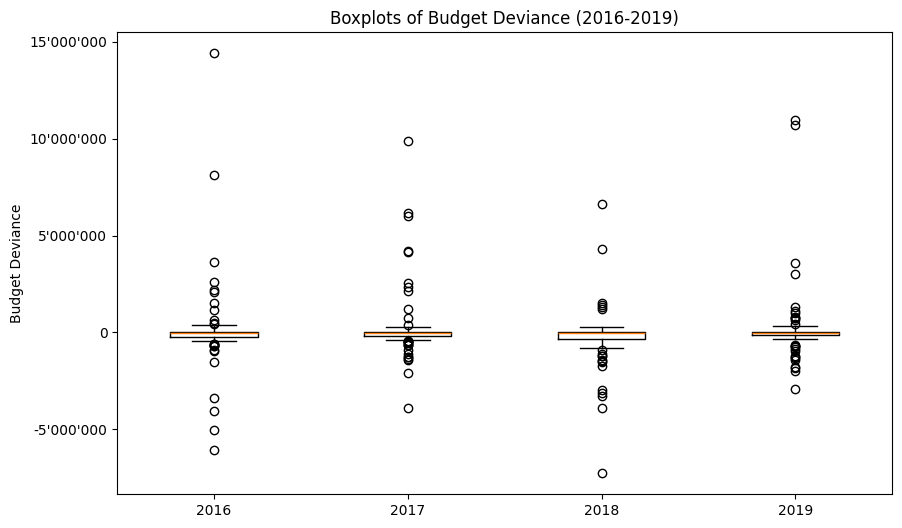

In [299]:
# Function to format the axis labels
def format_axis_labels(value, tick_number):
    return f"{int(value):,}".replace(",", "'")

# Creating the boxplots
plt.figure(figsize=(10, 6))
plt.boxplot([merged_df['Abweichung 2016'], merged_df['Abweichung 2017'], 
             merged_df['Abweichung 2018'], merged_df['Abweichung 2019']],
            labels=['2016', '2017', '2018', '2019'])

# Setting custom y-axis formatter
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(format_axis_labels))

plt.title('Boxplots of Budget Deviance (2016-2019)')
plt.ylabel('Budget Deviance')
plt.show()

In [300]:
# Set pandas display option to suppress scientific notation
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x).replace(',', "'"))

# Calculate summary statistics
summary_stats = merged_df[['Abweichung 2016', 'Abweichung 2017', 'Abweichung 2018', 'Abweichung 2019']].describe()

# Display the summary statistics table
summary_stats

,Abweichung 2016,Abweichung 2017,Abweichung 2018,Abweichung 2019
count,97.00,97.00,97.00,97.00
mean,78'664.22,192'960.86,-232'297.73,147'518.79
std,2'055'301.93,1'627'225.79,1'376'373.71,1'742'725.06
min,-6'067'992.00,-3'890'535.00,-7'277'074.00,-2'903'371.00
25%,-216'667.00,-166'565.00,-343'769.00,-159'110.00
50%,-20'491.00,-46'597.00,-35'341.00,-25'418.00
75%,24'174.00,12'806.00,22'408.00,41'988.00
max,14'413'049.00,9'894'942.00,6'648'656.00,10'966'009.00


The following kst are especially interesting - as they are max. values

In [301]:
#Check min outlier

# Columns to check
columns_to_check = ['Konto','Abweichung 2016', 'Abweichung 2017', 'Abweichung 2018', 'Abweichung 2019']

# Find the minimum values in each column and identify the overall min
min_values = merged_df[columns_to_check].min()
overall_min_value = min_values.min()

# Find the row index where the overall minimum value occurs
min_row_idx = merged_df[merged_df[columns_to_check] == overall_min_value].any(axis=1).idxmax()

# Print only the specified columns for the row with the lowest value
print("Row with the lowest value across specified columns:")
print(merged_df.loc[min_row_idx, columns_to_check])

Row with the lowest value across specified columns:
0
Konto                    611.00
Abweichung 2016   -5'044'347.00
Abweichung 2017     -474'760.00
Abweichung 2018   -7'277'074.00
Abweichung 2019   -1'835'646.00
Name: 71, dtype: float64


In [302]:
#Check max outlier

# Columns to check
columns_to_check = ['Konto','Abweichung 2016', 'Abweichung 2017', 'Abweichung 2018', 'Abweichung 2019']

# Find the maximum values in each column and identify the overall max
max_values = merged_df[columns_to_check].max()
overall_max_value = max_values.max()

# Find the row index where the overall maximum value occurs
max_row_idx = merged_df[merged_df[columns_to_check] == overall_max_value].any(axis=1).idxmax()

# Print only the specified columns for the row with the highest value
print("Row with the highest value across specified columns:")
print(merged_df.loc[max_row_idx, columns_to_check])

Row with the highest value across specified columns:
0
Konto                    251.00
Abweichung 2016   14'413'049.00
Abweichung 2017    9'894'942.00
Abweichung 2018    4'311'890.00
Abweichung 2019    2'991'049.00
Name: 18, dtype: float64


Finding the full cost account description for the account of interest

In [303]:
# Load the DataFrame from the CSV file
kostenstellen_df = pd.read_csv('kostenstellen.csv')
kostenstellen_df.head()


,kst_bisher,kst_neu,abk,kst_bezeichnung,id,nr
0,1.00,NaN,BB,Bürgerschaft und Behörden,3a73602e24f4e9f6bc49d5a7732de09c9be6dba8,1
1,11.00,1'100.00,NaN,Stadtparlament und parlamentarische Kommissionen,337ac5335af5c15cc0b2b32a078dd66b0a992052,3
2,12.00,1'200.00,NaN,Stadtrat,e6ab826cacfdae8944f6f75f7652d127488b49e2,6
3,15.00,1'500.00,NaN,Ombudsstelle,e30e49a0c4dea4bd005a3a1ae7617a80f726c1c1,9
4,19.00,190.00,KOM,Kommunikation,29a496727a625b8082f192147ba9dc52054fbb7d,28


In [305]:
# Number to check
number_to_check = 251  # Replace with the number you're looking for

# Check if the number is present in either 'kst_bisher' or 'kst_neu'
result_df = kostenstellen_df[(kostenstellen_df['kst_bisher'] == number_to_check) | (kostenstellen_df['kst_neu'] == number_to_check)]

if not result_df.empty:
    # If the number is found, display the rows
    print(result_df)
else:
    # If the number is not found, print a message
    print("this kst does not exist")

this kst does not exist
